# Dota 2 TI 12

October 27 - 29, Seattle, Climate Pledge Arena

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as st

## Get The Data

Started with obtaining all the [premium matches from datdota](https://datdota.com/matches?tier=premium) as a CSV.

In [2]:
premium_matches = pd.read_csv('../data/premium_matches.csv')

In [3]:
premium_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Match ID         2500 non-null   int64  
 1   Series           2485 non-null   float64
 2   League           2500 non-null   int64  
 3   Start Date/Time  2500 non-null   object 
 4   Match Length     2500 non-null   object 
 5   Duration (secs)  2500 non-null   int64  
 6   Kills Score      2500 non-null   object 
 7   Unnamed: 7       2500 non-null   object 
 8   Winner           2500 non-null   object 
 9   Radiant Team     2500 non-null   object 
 10  Radiant Players  2500 non-null   object 
 11  Dire Team        2500 non-null   object 
 12  Dire Players     2500 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 254.0+ KB


First thing, convert Start Date/Time to datetime and then select the 'league' `15728` (TI 12).

Found out that some times are off (like 6:00 instead of 18:00). As a first pass, I decided to just look at the games played during the finals weekend. So October 27 - 29, Seattle, Climate Pledge Arena. That was a total of 10 series and I simply identified them by day.

In [4]:
premium_matches['Start Date/Time'] = pd.to_datetime(premium_matches['Start Date/Time'])

premium_matches = premium_matches.loc[premium_matches['League'] == 15728]

In [5]:
#premium_matches['Start Date/Time'].dt.date.unique()

# # note there's no events yet after 10/29
# finals_start = premium_matches['Start Date/Time'] >= pd.to_datetime('2023-10-27')
# finals_end = premium_matches['Start Date/Time'] <= pd.to_datetime('2023-10-29')

In [6]:
premium_matches.loc[premium_matches['Series'].isin([819833, 819879, 819908, 819927]), 'Match Day'] = 'Friday'
premium_matches.loc[premium_matches['Series'].isin([820160, 820236, 820265, 820276]), 'Match Day'] = 'Saturday'
premium_matches.loc[premium_matches['Series'].isin([820513, 820565]), 'Match Day'] = 'Sunday'

In [7]:
finals_matches = premium_matches.dropna(subset='Match Day').copy()

## Explore the data

In [8]:
print('Total Matches over the weekend:', len(finals_matches))
print(finals_matches['Match Day'].value_counts().sort_index())

Total Matches over the weekend: 24
Friday       9
Saturday    10
Sunday       5
Name: Match Day, dtype: int64


In [9]:
print('min games that could be played', 9*2 + 3)
print('max games that could be played', 9*3 + 5)

min games that could be played 21
max games that could be played 32


Once I did this part I got curious as to what were the odds of there being 24 games. And so why not simulate it using Monte Carlo techniques?

In [10]:
teams_list = ['Team Spirit', 'Team Liquid', 'LGD Gaming', 'Azure Ray',
              'nouns', 'Gaimin Gladiators', 'BetBoom Team', 'Virtus.pro']

The idea is now to simulate each part of the tournament, as it unfolded. Assumptions:
- Start with slightly imbalanced win probability, at 53% plus or minus 2% (sigma)
- Each game is independent; could be because of hero picks (better/worst drafts, more comfortable), or because one team gets into the headspace of the other

possible extensions: 
- do the actual bracket
- games within series affect win probability for next one (+morale)

In [12]:
# to simulate multiple turnaments
sim_num = 100000
simulations = []

for sim in range(sim_num):

    # reset variables in each sim
    series = [0, 0]
    series_win = 2
    series_num = 1
    tournament = []

    # simulate new win probabilities for each tournament (10 series)
    win_prob1 = np.random.normal(0.53, 0.02, 10)
    win_prob2 = 1 - win_prob1

    while True:

        # for the finals, 3 wins are needed for series
        if series_num == 10:
            series_win = 3

        # select 0 (first team wins) or 1 (second team wins)
        team_win = np.random.choice([0,1], p=[win_prob1[series_num - 1], win_prob2[series_num - 1]])

        # add a point in the series for winning team
        series[team_win] += 1

        # if the winning team won the series
        if series[team_win] == series_win:

            # save the series score
            tournament.extend(series)

            # start new series - aka reset variable
            series = [0, 0]

            # marks which series is being played
            series_num += 1

            # end the loop
            if series_num == 11:
                break
    
    # add to simulation
    simulations.append(tournament)


In [13]:
#pd.DataFrame(np.array(tournament).reshape(1,-1))
simulations_df = pd.DataFrame(simulations)

In [14]:
sim_mean = simulations_df.sum(axis=1).mean()
sim_std = simulations_df.sum(axis=1).std()

# since there were 24 matches
Z_observed = (24 - sim_mean) / sim_std

In [15]:
print('mean:', sim_mean)
print('std:', sim_std)
print('Z_obs:', Z_observed)
print('=================')
print(f'probability of there being 24 games or less is {100* st.norm.cdf(Z_observed):.2f}%')

mean: 26.5974
std: 1.6915796920095458
Z_obs: -1.5354878119365263
probability of there being 24 games or less is 6.23%


Lucky me, about 6.2% chance that I got to see 24 or less games, lol!

In [16]:
print('Time spent watching the games (not including draft or other commentary):')
print(pd.to_timedelta(f"{finals_matches['Duration (secs)'].sum()}s"))

Time spent watching the games (not including draft or other commentary):
0 days 17:36:07


In [87]:
print('Average game length:', pd.to_timedelta(f"{finals_matches['Duration (secs)'].mean()}s"))
print('Std dev game length:', pd.to_timedelta(f"{finals_matches['Duration (secs)'].std()}s"))

Average game length: 0 days 00:44:00.291666667
Std dev game length: 0 days 00:15:12.931993237


Start looking at kills

In [17]:
finals_matches[['Radiant Kills', 'Dire Kills']] = finals_matches['Kills Score'].str.split('-', expand=True)

finals_matches = finals_matches.drop(columns=['Kills Score', 'Unnamed: 7'])

finals_matches['Radiant Kills'] = finals_matches['Radiant Kills'].astype(int)
finals_matches['Dire Kills'] = finals_matches['Dire Kills'].astype(int)

finals_matches['Total Kills'] = finals_matches['Radiant Kills'] + finals_matches['Dire Kills']

In [18]:
print('Radiant kills:', finals_matches['Radiant Kills'].sum())
print('Dire Kills:', finals_matches['Dire Kills'].sum())
print('Total Kills:', finals_matches['Total Kills'].sum())

Radiant kills: 617
Dire Kills: 563
Total Kills: 1180


The longer the game takes, the more kills there are!

In [37]:
finals_matches['Duration (mins)'] = round(finals_matches['Duration (secs)'] / 60, 2)

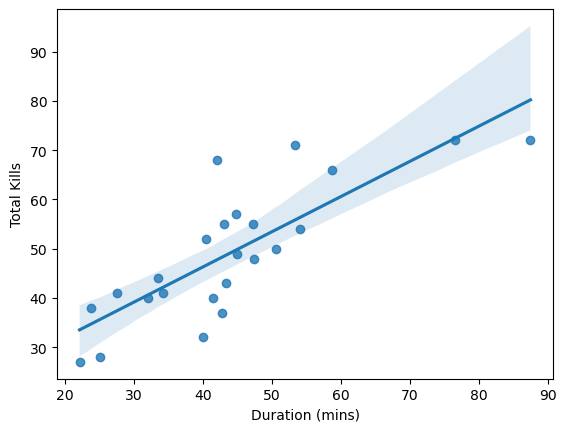

In [38]:
sns.regplot(data=finals_matches, x='Duration (mins)', y='Total Kills');

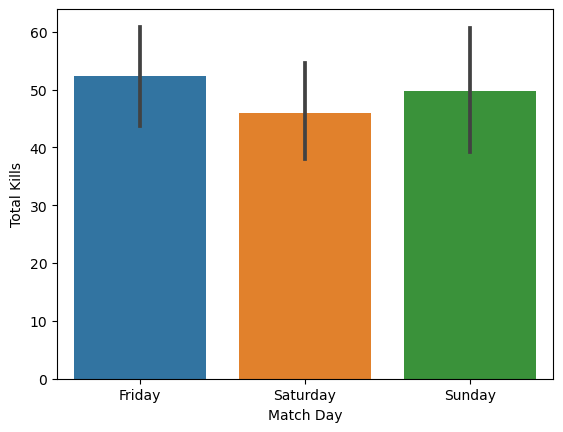

In [71]:
sns.barplot(finals_matches, x='Match Day', y='Total Kills', order=['Friday', 'Saturday', 'Sunday']);

Also length per day below.

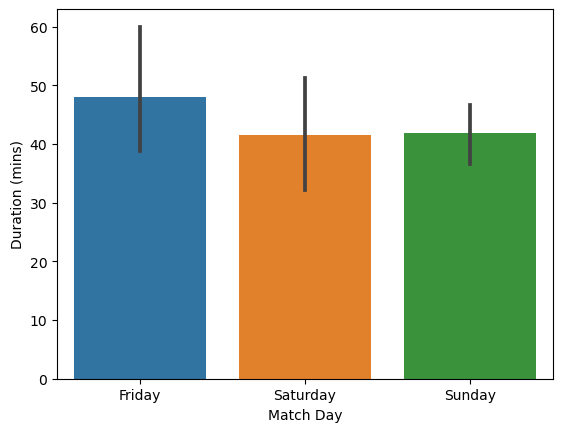

In [74]:
sns.barplot(finals_matches, x='Match Day', y='Duration (mins)', order=['Friday', 'Saturday', 'Sunday']);

How often does more kills mean the team wins?

In [47]:
finals_matches['Kill Difference'] = (
    np.where(finals_matches['Radiant Kills'] == finals_matches['Dire Kills'], 'Draw',
    np.where(finals_matches['Radiant Kills'] > finals_matches['Dire Kills'], 'Radiant', 'Dire'))
)

- When Radiant had the most kills, they won 100% of the time
- When the kills were equal, the Dire won
- When Dire had the most kills, they won 85% of the time

In [55]:
finals_matches.groupby(['Kill Difference', 'Winner'])['Match ID'].count()

Kill Difference  Winner 
Dire             Dire       11
                 Radiant     2
Draw             Dire        1
Radiant          Radiant    10
Name: Match ID, dtype: int64

In [60]:
print(f"Overall, the team that got most kills won {100*len(finals_matches.loc[finals_matches['Kill Difference'] == finals_matches['Winner']])/len(finals_matches)}% of time")


Overall, the team that got most kills won 87.5% of time


The next part is just for fun; what's the "worth" of various variables?

The official price of the tickets was $699, sold with Ticketmaster. Add to that:
- $5.55 (Order Processing Fee)
- $16.50 (Facility Charge)
- $151.45 (Service Fee)
- $7.58 (Tax)

And the final **actual** cost of tickets was $880.08

So let's say that I'm only interested in number of matches, or kills or total runtime; what is the "cost" of those? 

In [80]:
event_cost = 880.08

print('How much does it cost ...')
print(f"A Dota 2 game ${event_cost / len(finals_matches)}")
print(f"Each minute of a Dota 2 game ${event_cost / finals_matches['Duration (mins)'].sum():.2f}")
print(f"Each kill in a Dota 2 game ${event_cost / finals_matches['Total Kills'].sum():.2f}")

How much does it cost ...
A Dota 2 game $36.67
Each minute of a Dota 2 game $0.83
Each kill in a Dota 2 game $0.75


One final question. Let's say I'm only paying (in my mind) for watching my team. How much will each of the matches they play cost?

The two extremes are:
- My team looses right away, in a 0:2 and gets eliminated
- My team wins all the way to the grand final, each series is a 2:1 and the finals ends in 3:2 (or 2:3, making me highly upset for my team)
- it could also happen that my team begins in the upper brackets, loses the first match 1:2 and then continues same as in the point above

So at least, they'll play 2 games, at most, 17 which is a massive difference! If we're paying per length of game, that's variable since it can be quite different (44 min +- 15 min); but the average will do here.

In [90]:
print(f'max cost per my team game (2 games) is ${event_cost / 2}')
print(f'min cost per my team game (17 games) is ${event_cost / 17:.2f}')
print(f'max cost per minute of my team playing (2 games) is ${event_cost / (2 * finals_matches["Duration (mins)"].mean()):.2f}')
print(f'min cost per minute of team game (17 games) is ${event_cost / (17 * finals_matches["Duration (mins)"].mean()):.2f}')

max cost per my team game (2 games) is $440.04
min cost per my team game (17 games) is $51.77
max cost per minute of my team playing (2 games) is $10.00
min cost per minute of team game (17 games) is $1.18
